In [25]:
import os
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

In [20]:
BASE_DIR = '/content/drive/My Drive/Mali'
RANDOM_SEED = 8 # for reproducibility
RESULTS_DIR = os.path.join(BASE_DIR, 'results')
FIGURES_DIR = os.path.join(BASE_DIR, 'figures')

In [21]:
# import sys
# sys.path.append(BASE_DIR)
# from utils import merge_on_lat_lon, assign_groups, run_randomized_cv, run_spatial_cv

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
'''
Handful of utility functions used throughout the repo
'''

import math
import pandas as pd

def merge_on_lat_lon(df1, df2, keys=['cluster_lat', 'cluster_lon'], how='inner'):
    """
    Allows two dataframes to be merged on lat/lon
    Necessary because pandas has trouble merging on floats (understandably so)
    """
    df1 = df1.copy()
    df2 = df2.copy()
    
    # must use ints for merging, as floats induce errors
    df1['merge_lat'] = (10000 * df1[keys[0]]).astype(int)
    df1['merge_lon'] = (10000 * df1[keys[1]]).astype(int)
    
    df2['merge_lat'] = (10000 * df2[keys[0]]).astype(int)
    df2['merge_lon'] = (10000 * df2[keys[1]]).astype(int)
    
    df2.drop(keys, axis=1, inplace=True)
    merged = pd.merge(df1, df2, on=['merge_lat', 'merge_lon'], how=how)
    merged.drop(['merge_lat', 'merge_lon'], axis=1, inplace=True)
    return merged

def create_space(lat, lon, s=10):
    """Creates a s km x s km square centered on (lat, lon)"""
    v = (180/math.pi)*(500/6378137)*s # roughly 0.045 for s=10
    return lat - v, lon - v, lat + v, lon + v
    

In [24]:
# This is based on code from the Jean et al Github that is modified to work with Python3 and our metrics

import numpy as np
import pandas as pd
import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import sklearn.linear_model as linear_model
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.cluster import KMeans

def run_randomized_cv(X, y, k=5, k_inner=5, random_seed=7, points=10,
        alpha_low=1, alpha_high=5, to_print=False):
    """
    Run randomized CV on given X and y
    Returns r2, yhat
    """
    np.random.seed(random_seed)
    alphas = np.logspace(alpha_low, alpha_high, points)
    r2s = []
    y_hat = np.zeros_like(y)
    kf = KFold(n_splits=k, shuffle=True)
    fold = 0
    for train_idx, test_idx in kf.split(X):
        if to_print:
            print(f"fold: {fold}", end='\r')
        r2, y_p = evaluate_fold(X, y, train_idx, test_idx, k_inner, alphas, to_print)
        r2s.append(r2)
        y_hat[test_idx] = y_p
        fold += 1
    return np.mean(r2s), y_hat


def scale_features(X_train, X_test):
    """
    Scales features using StandardScaler.
    """
    X_scaler = StandardScaler(with_mean=True, with_std=False)
    X_train = X_scaler.fit_transform(X_train)
    X_test = X_scaler.transform(X_test)
    return X_train, X_test


def train_and_predict_ridge(alpha, X_train, y_train, X_test):
    """
    Trains ridge model and predicts test set.
    """
    ridge = linear_model.Ridge(alpha)
    ridge.fit(X_train, y_train)
    y_hat = ridge.predict(X_test)
    return y_hat

def find_best_alpha(X, y, k_inner, alphas, to_print=False):
    """
    Finds the best alpha in an inner fully randomized CV loop.
    """
    kf = KFold(n_splits=k_inner, shuffle=True)
    best_alpha = 0
    best_r2 = 0
    for idx, alpha in enumerate(alphas):
        y_hat = np.zeros_like(y)
        for train_idx, test_idx in kf.split(X):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            X_train, X_test = scale_features(X_train, X_test)
            y_hat[test_idx] = train_and_predict_ridge(alpha, X_train, y_train, X_test)
        r2 = metrics.r2_score(y, y_hat)
        if r2 > best_r2:
            best_alpha = alpha
            best_r2 = r2
    if to_print:
        print(best_alpha)
    return best_alpha


def evaluate_fold(X, y, train_idx, test_idx, k_inner, alphas, to_print=False):
    """
    Evaluates one fold of outer CV.
    """
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    best_alpha = find_best_alpha(X_train, y_train, k_inner, alphas, to_print)
    X_train, X_test = scale_features(X_train, X_test)
    y_test_hat = train_and_predict_ridge(best_alpha, X_train, y_train, X_test)
    r2 = metrics.r2_score(y_test, y_test_hat)
    return r2, y_test_hat


def run_spatial_cv(X, y, groups, k_inner=5, random_seed=7, points=10,
        alpha_low=1, alpha_high=5, to_print=False):
    """
    Run randomized CV on given X and y
    Returns r2, yhat
    """
    np.random.seed(random_seed)
    alphas = np.logspace(alpha_low, alpha_high, points)
    k = int(groups.max() + 1)
    r2s = []
    y_hat = np.zeros_like(y)
    fold = 0
    for i in range(k):
        train_idx = groups != i
        test_idx = groups == i
        if to_print:
            print(f"fold: {fold}", end='\r')
        r2, y_p = evaluate_fold(X, y, train_idx, test_idx, k_inner, alphas)
        # could use this function to do inner-fold spatial validation
        # r2, y_p = evaluate_spatial_fold(X, y, groups, train_idx, test_idx, alphas)
        r2s.append(r2)
        y_hat[test_idx] = y_p
        fold += 1
    return np.mean(r2s), y_hat

def evaluate_spatial_fold(X, y, groups, train_idx, test_idx, alphas):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    groups_train = groups[train_idx]
    best_alpha = find_best_alpha_spatial(X_train, y_train, groups_train, alphas)
    X_train, X_test = scale_features(X_train, X_test)
    y_test_hat = train_and_predict_ridge(best_alpha, X_train, y_train, X_test)
    r2 = metrics.r2_score(y_test, y_test_hat)
    return r2, y_test_hat

def find_best_alpha_spatial(X, y, groups, alphas):
    """
    Finds the best alpha in an inner spatial CV loop.
    """
    gs = np.unique(groups)
    best_alpha = 0
    best_r2 = 0
    for alpha in alphas:
        y_hat = np.zeros_like(y)
        for g in gs:
            # hold out each g in the inner spatial loop while choosing the best alpha
            train_idx = groups != g
            test_idx = groups == g
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            X_train, X_test = scale_features(X_train, X_test)
            y_hat[test_idx] = train_and_predict_ridge(alpha, X_train, y_train, X_test)
        r2 = metrics.r2_score(y, y_hat)
        if r2 > best_r2:
            best_alpha = alpha
            best_r2 = r2
    return best_alpha

def assign_groups(df, k, random_seed=7):
    ''' Assign clusters in df (columns cluster_lat, cluster_lon) into k groups, also returns cluster centers'''
    np.random.seed(random_seed)
    km = KMeans(k)
    return km.fit_predict(df[['cluster_lat', 'cluster_lon']]), km.cluster_centers_


In [26]:
def load_country(country):
    '''
    Organizes the country's dataframe so that each index corresponds to the index in the cluster features
    Returns the cluster features and the organized dataframe
    '''
    country_processed_dir = os.path.join(BASE_DIR, 'processed')
    country_results_dir = os.path.join(RESULTS_DIR, country, 'cnn')
    x = np.load(os.path.join(country_results_dir, 'cluster_feats.npy'))
    cluster_list = pickle.load(open(os.path.join(country_results_dir, 'cluster_order.pkl'), 'rb'))
    cluster_list = pd.DataFrame.from_records(cluster_list, columns=['cluster_lat', 'cluster_lon'])
    cluster_list['feat_index'] = np.arange(len(cluster_list))
    
    df_clusters = pd.read_csv(os.path.join(country_processed_dir, 'clusters.csv'))
#     assert len(df_clusters) == len(cluster_list)

    df = merge_on_lat_lon(df_clusters, cluster_list, keys=['cluster_lat', 'cluster_lon'])
#     assert len(df) == len(df_clusters) == len(cluster_list)
    df.sort_values('feat_index', ascending=True, inplace=True)
    return x, df

In [27]:
x_mli, df_mli = load_country('mali_2015')

In [28]:
y_mli = df_mli['cons_pc'].values

In [29]:
def test_fully_randomized_cv():
    print("Testing fully randomized CV:\n--------------\n")
    # x_all = np.concatenate([x_mw, x_eth, x_ng], axis=0)
    # y_all = np.concatenate([y_mw, y_eth, y_ng], axis=0)
    r2_direct, _ = run_randomized_cv(x_mli, y_mli, random_seed=RANDOM_SEED, to_print=False)
    r2_log, _ = run_randomized_cv(x_mli, np.log(y_mli), random_seed=RANDOM_SEED)
    print(f"For fully randomized cv: direct r2: {r2_direct}, log r2: {r2_log}")
    
def test_spatial_cv():
    print("Testing per country spatial CV:\n--------------\n")
    groups, _ = assign_groups(df_mli, k=5, random_seed=RANDOM_SEED)
    r2_direct, _ = run_spatial_cv(x_mli, y_mli, groups, random_seed=RANDOM_SEED)
    r2_log, _ = run_spatial_cv(x_mli, np.log(y_mli), groups, random_seed=RANDOM_SEED)
    print(f"For {'Mali'}, direct r2: {r2_direct}, log r2: {r2_log}")
    
# def test_cross_country_cv():
#     print("Testing cross country CV:\n--------------\n")
#     x_all = np.concatenate([x_mw, x_eth, x_ng], axis=0)
#     y_all = np.concatenate([y_mw, y_eth, y_ng], axis=0)
#     groups = np.zeros_like(y_mli)
#     groups[len(y_mw) : len(y_mw) + len(y_eth)] = 1 # ethiopia indices become 1
#     groups[len(y_mw) + len(y_eth):] = 2 # nigeria indices become 2
#     r2_direct, _ = run_spatial_cv(x_all, y_all, groups, random_seed=RANDOM_SEED, k_inner=10)
#     r2_log, _ = run_spatial_cv(x_all, np.log(y_all), groups, random_seed=RANDOM_SEED, k_inner=10)
#     print(f"For cross country cv: direct r2: {r2_direct}, log r2: {r2_log}")

In [30]:
test_fully_randomized_cv()

Testing fully randomized CV:
--------------

For fully randomized cv: direct r2: 0.05050312124677716, log r2: 0.08923873278386137


In [31]:
test_spatial_cv()

Testing per country spatial CV:
--------------

For Mali, direct r2: -0.2371950319688636, log r2: -0.2129109726353937


In [32]:
def plot_predictions(y, yhat, r2, country, max_y=None):
    if max_y is not None:
        yhat = yhat[y < max_y]
        y = y[y < max_y]
    fig = plt.figure(figsize=(8,5))
    plt.scatter(y, yhat, alpha=0.6, color = 'black')
    plt.plot(np.unique(y), np.poly1d(np.polyfit(y, yhat, 1))(np.unique(y)), color='g')
    # plt.text(15.5, 7, f'r^2={round(r2, 2)}', size=12)
    plt.xlabel('Actual Consumption($/day)',c = 'white')
    plt.ylabel('Predicted Consumption($/day)', c = 'white')
    plt.title(f'{country} Results',c = 'white')
    return fig

In [33]:
r2, yhat_mli = run_randomized_cv(x_mli, y_mli, random_seed=RANDOM_SEED, to_print=False)

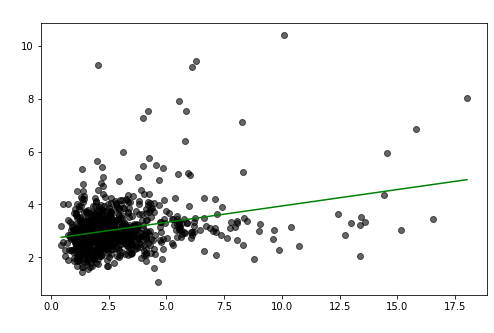

In [34]:
fig = plot_predictions(y_mli, yhat_mli, r2, 'Mali', max_y=20)

In [35]:
fig.savefig(os.path.join(FIGURES_DIR, 'mali_results.png'))